# Model Testing and Predictions on Smaller images

# VGG19 trained on AOI

# Multiclass prediction task


# 1. Set up

In [1]:
 from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 5360956413764901158
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 16154099712
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 4395531007338646407
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
 xla_global_id: 416903419]

In [3]:
!pip install tensorflow-addons --quiet

In [4]:
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.models import Model, save_model, load_model
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.applications.vgg19 import preprocess_input
from keras import backend as K
import tensorflow_addons as tfa
import os
import tempfile


from keras.utils.vis_utils import plot_model


In [5]:
# Define paths:
pathtoCSV = '/content/drive/Shareddrives/Eye_Tracking_NN_SD/Image_processing/Publishable_material/CSV_Files/'
pathtoImages = '/content/drive/Shareddrives/Eye_Tracking_NN_SD/Image_processing/Publishable_material/Images/'
pathtoSave = '/content/drive/Shareddrives/Eye_Tracking_NN_SD/Image_processing/Publishable_material/Saved_models/VGG19/'
pathtoResults = '/content/drive/Shareddrives/Eye_Tracking_NN_SD/Image_processing/Publishable_material/Models_performance/VGG19/Strategic_sophistication/'

#2. Input Pipeline

In [6]:
labels_csv = pd.read_csv(pathtoCSV + 'train_val_levels.csv',dtype=str)

In [7]:
def image_generator(pathtoImages ):
  train_datagen = ImageDataGenerator(
      preprocessing_function = preprocess_input,
  )
  val_datagen = ImageDataGenerator(
      preprocessing_function = preprocess_input,
  )
  labels_csv['Levels'] = labels_csv['Levels'].astype(str)
  labels_csv['code'] = labels_csv['code'].astype(str)


  train_generator = train_datagen.flow_from_dataframe(
      labels_csv,
      directory = pathtoImages + 'Train',
      x_col = 'code',
      y_col = 'Levels',
      target_size = (224,224),
      color_mode='rgb',
      shuffle=True,
      seed= 1,
      class_mode = 'categorical',
      batch_size = 16
  )

  val_generator = val_datagen.flow_from_dataframe(
      labels_csv,
      directory = pathtoImages + 'Validation',
      x_col = 'code',
      y_col = 'Levels',
      target_size = (224,224),
      color_mode='rgb',
      shuffle=True,
      seed= 1,
      class_mode = 'categorical',
      batch_size = 16
  )
  return train_generator, val_generator

train_generator, val_generator = image_generator(pathtoImages)

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 480 invalid image filename(s) in x_col="code". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 1700 validated image filenames belonging to 3 classes.
Found 480 validated image filenames belonging to 3 classes.


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 1700 invalid image filename(s) in x_col="code". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


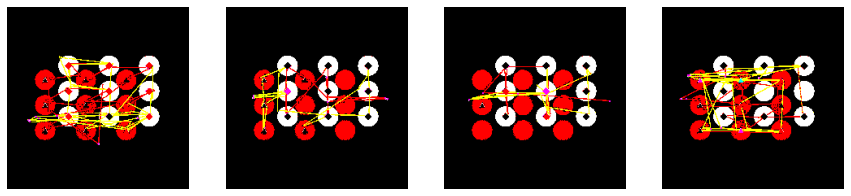

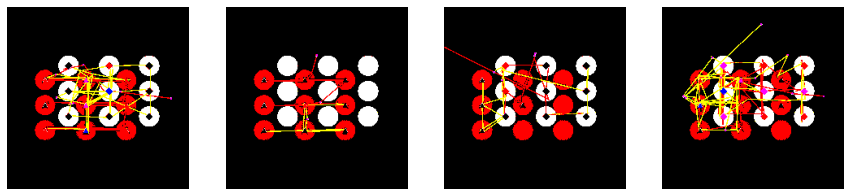

In [8]:
# plotting train images
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(15,15))

for i in range(4):
  # convert to unsigned integers for plotting
  image = next(train_generator)[0][i].astype('float')
  # plot raw pixel data
  ax[i].imshow(image)
  ax[i].axis('off')

# plotting val images
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(15,15))

for i in range(4):

  # convert to unsigned integers for plotting
  image = next(val_generator)[0][i].astype('float')
  # plot raw pixel data
  ax[i].imshow(image)
  ax[i].axis('off')

#3. Best model found by Bayesian Tuner

Trial summary of best model found by Bayesian tuner:\
units_1: 1024\
dropout_1: 0.5000000000000001



In [9]:
# Define early-stopping:
early_stopping_1 = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    verbose=1,
    patience=4, 
    mode='auto',
    restore_best_weights=True)

In [10]:
def recall(y_true, y_pred):
    y_true = K.ones_like(y_true) 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    all_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    
    recall = true_positives / (all_positives + K.epsilon())
    return recall


In [11]:
METRICS = [  
      keras.metrics.CategoricalAccuracy(name='accuracy'),
      recall,
      keras.metrics.AUC(name='auc', multi_label = True),
      keras.metrics.AUC(curve = 'PR', name='PR', multi_label = True),
      tfa.metrics.F1Score(name = 'f1macro', num_classes = 3, average = 'macro'),
      tfa.metrics.F1Score(name = 'f1weighted', num_classes = 3, average = 'weighted'),
]

In [12]:
# Original code source for regularizer: https://sthalles.github.io/keras-regularizer/

def build_model():
  base_model = VGG19(weights='imagenet', include_top=False)
  for layers in base_model.layers:
    layers.trainable=False
  x= base_model.output
  x= GlobalAveragePooling2D()(x)
  x= Dense(1024,activation='relu')(x)
  x=Dropout(0.5000000000000001)(x)
  output=Dense(3,activation='softmax')(x)
  model=Model(inputs=base_model.input,outputs=output)
  regularizer=tf.keras.regularizers.L1L2(1e-5)
  if not isinstance(regularizer, tf.keras.regularizers.Regularizer):
    print("Regularizer must be a subclass of tf.keras.regularizers.Regularizer")
    return model

  for layer in model.layers:
    for attr in ['kernel_regularizer']:
      if hasattr(layer, attr):
        setattr(layer, attr, regularizer)

  # When we change the layers attributes, the change only happens in the model config file
  model_json = model.to_json()

  # Save the weights before reloading the model.
  tmp_weights_path = os.path.join(tempfile.gettempdir(), 'tmp_weights.h5')
  model.save_weights(tmp_weights_path)

  # load the model from the config
  model = tf.keras.models.model_from_json(model_json)
    
  # Reload the model weights
  model.load_weights(tmp_weights_path, by_name=True)
  lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(1e-5, decay_steps=100000, decay_rate=0.75, staircase=True)
  opt = SGD(learning_rate = lr_schedule, momentum=0.99) 
  model.compile(optimizer=opt, loss=tfa.losses.SigmoidFocalCrossEntropy(gamma = 2, alpha= 0.25, reduction=tf.keras.losses.Reduction.AUTO), metrics= METRICS)
  return model

model = build_model()

In [13]:
 model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [14]:
history = model.fit(
    train_generator,
    batch_size = 16,
    epochs = 30,
    callbacks= early_stopping_1,
    validation_data = val_generator,
    shuffle = True
)

Epoch 1/30
107/107 [==============================] - 1770s 16s/step - loss: 3.0244 - accuracy: 0.4059 - recall: 0.3197 - auc: 0.5305 - PR: 0.3576 - f1macro: 0.3587 - f1weighted: 0.4063 - val_loss: 1.7986 - val_accuracy: 0.5979 - val_recall: 0.3028 - val_auc: 0.6873 - val_PR: 0.5155 - val_f1macro: 0.4905 - val_f1weighted: 0.5550
Epoch 2/30
107/107 [==============================] - 93s 874ms/step - loss: 2.4979 - accuracy: 0.4847 - recall: 0.3154 - auc: 0.6225 - PR: 0.4358 - f1macro: 0.4374 - f1weighted: 0.4855 - val_loss: 1.9961 - val_accuracy: 0.6062 - val_recall: 0.3021 - val_auc: 0.7234 - val_PR: 0.5567 - val_f1macro: 0.4802 - val_f1weighted: 0.5509
Epoch 3/30
107/107 [==============================] - 93s 867ms/step - loss: 2.1999 - accuracy: 0.4676 - recall: 0.3076 - auc: 0.6308 - PR: 0.4503 - f1macro: 0.4327 - f1weighted: 0.4720 - val_loss: 1.7040 - val_accuracy: 0.6000 - val_recall: 0.2674 - val_auc: 0.7404 - val_PR: 0.5631 - val_f1macro: 0.5148 - val_f1weighted: 0.5701
Epoch 4

In [15]:
'''def plot_metrics(history, name_file):

  Funcitons to plot metrics ('accuracy', 'tp', 'fp', 'loss', 'tn', 'fn',  'precision', 'recall', 'auc') in subplots.
  Adjust the figsize for overlal size of plot
  Adjust fontsize for labels
  Adjust linewidth for line of graphs

  Args:
   History - tensorflow object
  
  Returns:

  metrics = ['loss', 'accuracy','recall', 'auc', 'PR', 'f1macro', 'f1weighted' ]
  fig, ax = plt.subplots(3,3, figsize=(30,20))
  fig.suptitle('Model Metric Plots',fontsize=40)
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(3,3,n+1)
    plt.plot(history.epoch, history.history[metric], label='Train', linewidth=3)
    plt.plot(history.epoch, history.history['val_'+metric], linestyle="--", label='Val', linewidth=3)
    plt.xlabel('Epoch', fontsize=10)
    plt.title(str(name))
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])

    #plt.legend(fontsize=10)
    #plt.savefig(pathtoResults + name_file)'''

'def plot_metrics(history, name_file):\n\n  Funcitons to plot metrics (\'accuracy\', \'tp\', \'fp\', \'loss\', \'tn\', \'fn\',  \'precision\', \'recall\', \'auc\') in subplots.\n  Adjust the figsize for overlal size of plot\n  Adjust fontsize for labels\n  Adjust linewidth for line of graphs\n\n  Args:\n   History - tensorflow object\n  \n  Returns:\n\n  metrics = [\'loss\', \'accuracy\',\'recall\', \'auc\', \'PR\', \'f1macro\', \'f1weighted\' ]\n  fig, ax = plt.subplots(3,3, figsize=(30,20))\n  fig.suptitle(\'Model Metric Plots\',fontsize=40)\n  for n, metric in enumerate(metrics):\n    name = metric.replace("_"," ").capitalize()\n    plt.subplot(3,3,n+1)\n    plt.plot(history.epoch, history.history[metric], label=\'Train\', linewidth=3)\n    plt.plot(history.epoch, history.history[\'val_\'+metric], linestyle="--", label=\'Val\', linewidth=3)\n    plt.xlabel(\'Epoch\', fontsize=10)\n    plt.title(str(name))\n    if metric == \'loss\':\n      plt.ylim([0, plt.ylim()[1]])\n\n    #plt.le

In [16]:
'''plot_metrics(history= history, name_file ='history_val.png')'''

"plot_metrics(history= history, name_file ='history_val.png')"

In [17]:
'''#convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history.history)
frames = [hist_df]
result = pd.concat(frames)
# or save to csv: 
hist_csv_file = pathtoResults + 'history_val.csv'
with open(hist_csv_file, mode='w') as f:
    result.to_csv(f)'''

"#convert the history.history dict to a pandas DataFrame:     \nhist_df = pd.DataFrame(history.history)\nframes = [hist_df]\nresult = pd.concat(frames)\n# or save to csv: \nhist_csv_file = pathtoResults + 'history_val.csv'\nwith open(hist_csv_file, mode='w') as f:\n    result.to_csv(f)"

#4. Fine tune model with best tuning identified by Randomsearch

Trial summary\
Hyperparameters:\
num_frozen_layers: 3\
learning_rate: 1e-05

In [18]:
# Define early-stopping:
early_stopping_2 = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    verbose=1,
    patience=3, 
    mode='auto',
    restore_best_weights=True)

In [19]:
# reset the train and validation generators:
train_generator.reset()
val_generator.reset()

In [20]:
for layer in model.layers[3:]:
	layer.trainable = True

In [21]:
lr_sched = tf.keras.optimizers.schedules.ExponentialDecay(1e-5, decay_steps=100000, decay_rate=0.75, staircase=True)
opt_2 = SGD(learning_rate = lr_sched, momentum=0.99) 
model.compile(optimizer=opt_2, loss=tfa.losses.SigmoidFocalCrossEntropy(gamma = 2, alpha= 0.25, reduction=tf.keras.losses.Reduction.AUTO), metrics= METRICS)

In [22]:
history_2 = model.fit(
    train_generator,
    batch_size = 16,
    epochs = 10,
    callbacks= early_stopping_2,
    validation_data = val_generator,
    shuffle = True
)

Epoch 1/10
107/107 [==============================] - 102s 916ms/step - loss: 1.5670 - accuracy: 0.6381 - recall: 0.1151 - auc: 0.7666 - PR: 0.6035 - f1macro: 0.5766 - f1weighted: 0.6251 - val_loss: 1.5696 - val_accuracy: 0.6542 - val_recall: 0.1118 - val_auc: 0.7577 - val_PR: 0.5862 - val_f1macro: 0.5341 - val_f1weighted: 0.6059
Epoch 2/10
107/107 [==============================] - 95s 891ms/step - loss: 1.5655 - accuracy: 0.6265 - recall: 0.1120 - auc: 0.7651 - PR: 0.6090 - f1macro: 0.5476 - f1weighted: 0.6056 - val_loss: 1.5798 - val_accuracy: 0.6083 - val_recall: 0.1181 - val_auc: 0.7655 - val_PR: 0.5920 - val_f1macro: 0.5108 - val_f1weighted: 0.5729
Epoch 3/10
107/107 [==============================] - 98s 913ms/step - loss: 1.5589 - accuracy: 0.6524 - recall: 0.1221 - auc: 0.7866 - PR: 0.6447 - f1macro: 0.5826 - f1weighted: 0.6346 - val_loss: 1.5639 - val_accuracy: 0.6479 - val_recall: 0.1139 - val_auc: 0.7742 - val_PR: 0.6032 - val_f1macro: 0.5426 - val_f1weighted: 0.6098
Epoch 

In [23]:
''';!mkdir -p saved_models_and_weights
model.save(filepath = pathtoSave + 'VGG_19_Strategic_sophistication_best_model')'''

";!mkdir -p saved_models_and_weights\nmodel.save(filepath = pathtoSave + 'VGG_19_Strategic_sophistication_best_model')"

In [24]:
'''plot_metrics(history=history_2, name_file = 'history_best_model_val.png')'''

"plot_metrics(history=history_2, name_file = 'history_best_model_val.png')"

In [25]:
'''
#convert the history.history dict to a pandas DataFrame:     
hist_df_2 = pd.DataFrame(history_2.history)
frames = [hist_df_2]
result = pd.concat(frames)
# or save to csv: 
hist_csv_file = pathtoResults + 'history_best_model_val.csv'
with open(hist_csv_file, mode='w') as f:
    result.to_csv(f)
    '''

"\n#convert the history.history dict to a pandas DataFrame:     \nhist_df_2 = pd.DataFrame(history_2.history)\nframes = [hist_df_2]\nresult = pd.concat(frames)\n# or save to csv: \nhist_csv_file = pathtoResults + 'history_best_model_val.csv'\nwith open(hist_csv_file, mode='w') as f:\n    result.to_csv(f)\n    "

#5. Test Generators

In [26]:
# load test data:
labels_xl = pd.read_csv(pathtoCSV + 'test_L1L2.csv',dtype=str)

# Paths to test images:
test_percentage = 'test_percentages/'
test_timing = 'test_timings/'

In [27]:
def load_test_images(test_full, test_80, test_50, test_30, test_15, test_15s, test_10s, test_5s, test_2s):
  test_datagen = ImageDataGenerator(
      preprocessing_function = preprocess_input,
  )
  labels_xl['Levels'] = labels_xl['Levels'].astype(str)
  labels_xl['code'] = labels_xl['code'].astype(str)

  test_generator_full_images = test_datagen.flow_from_dataframe(
      labels_xl,
      directory = test_full,
      x_col = 'code',
      y_col = 'Levels',
      target_size = (224,224),
      color_mode='rgb',
      shuffle=False,
      seed= 1,
      class_mode = 'categorical',
      batch_size = 16
)
  test_generator_80_percent = test_datagen.flow_from_dataframe(
      labels_xl,
      directory = test_80,
      x_col = 'code',
      y_col = 'Levels',
      target_size = (224,224),
      color_mode='rgb',
      shuffle=False,
      seed= 1,
      class_mode = 'categorical',
      batch_size = 16
  )
  test_generator_50_percent = test_datagen.flow_from_dataframe(
      labels_xl,
      directory = test_50,
      x_col = 'code',
      y_col = 'Levels',
      target_size = (224,224),
      color_mode='rgb',
      shuffle=False,
      seed= 1,
      class_mode = 'categorical',
      batch_size = 16
  )
  test_generator_30_percent = test_datagen.flow_from_dataframe(
      labels_xl,
      directory = test_30,
      x_col = 'code',
      y_col = 'Levels',
      target_size = (224,224),
      color_mode='rgb',
      shuffle=False,
      seed= 1,
      class_mode = 'categorical',
      batch_size = 16
  )
  test_generator_15_percent = test_datagen.flow_from_dataframe(
      labels_xl,
      directory = test_15,
      x_col = 'code',
      y_col = 'Levels',
      target_size = (224,224),
      color_mode='rgb',
      shuffle=False,
      seed= 1,
      class_mode = 'categorical',
      batch_size = 16
  )
  test_generator_15_secs = test_datagen.flow_from_dataframe(
      labels_xl,
      directory = test_15s,
      x_col = 'code',
      y_col = 'Levels',
      target_size = (224,224),
      color_mode='rgb',
      shuffle=False,
      seed= 1,
      class_mode = 'categorical',
      batch_size = 16
  )
  test_generator_10_secs = test_datagen.flow_from_dataframe(
      labels_xl,
      directory = test_10s,
      x_col = 'code',
      y_col = 'Levels',
      target_size = (224,224),
      color_mode='rgb',
      shuffle=False,
      seed= 1,
      class_mode = 'categorical',
      batch_size = 16
  )
  test_generator_5_secs = test_datagen.flow_from_dataframe(
      labels_xl,
      directory = test_5s,
      x_col = 'code',
      y_col = 'Levels',
      target_size = (224,224),
      color_mode='rgb',
      shuffle=False,
      seed= 1,
      class_mode = 'categorical',
      batch_size = 16
  )
  test_generator_2_secs = test_datagen.flow_from_dataframe(
      labels_xl,
      directory = test_2s,
      x_col = 'code',
      y_col = 'Levels',
      target_size = (224,224),
      color_mode='rgb',
      shuffle=False,
      seed= 1,
      class_mode = 'categorical',
      batch_size = 16
  )

  return test_generator_full_images, test_generator_80_percent, test_generator_50_percent, test_generator_30_percent, test_generator_15_percent, test_generator_15_secs, test_generator_10_secs, test_generator_5_secs, test_generator_2_secs

In [28]:
# Load all images
test_full = pathtoImages + 'Test/'
test_80 = pathtoImages + test_percentage + 'Test_80/'
test_50 = pathtoImages + test_percentage + 'Test_50/'
test_30 = pathtoImages + test_percentage + 'Test_30/'
test_15 = pathtoImages + test_percentage + 'Test_15/'
test_15s = pathtoImages + test_timing + 'Test_15s/'
test_10s = pathtoImages + test_timing + 'Test_10s/'
test_5s = pathtoImages + test_timing + 'Test_5s/'
test_2s = pathtoImages + test_timing + 'Test_2s/'
test_generator_full_images, test_generator_80_percent, test_generator_50_percent,  test_generator_30_percent, test_generator_15_percent, test_generator_15_secs, test_generator_10_secs, test_generator_5_secs, test_generator_2_secs = load_test_images(test_full, test_80, test_50, test_30, test_15, test_15s, test_10s, test_5s, test_2s)

Found 250 validated image filenames belonging to 3 classes.
Found 250 validated image filenames belonging to 3 classes.
Found 250 validated image filenames belonging to 3 classes.
Found 250 validated image filenames belonging to 3 classes.
Found 250 validated image filenames belonging to 3 classes.
Found 250 validated image filenames belonging to 3 classes.
Found 250 validated image filenames belonging to 3 classes.
Found 250 validated image filenames belonging to 3 classes.
Found 250 validated image filenames belonging to 3 classes.


#6. Eval

In [29]:
evaluation_full = model.evaluate(test_generator_full_images)
evaluation_80 = model.evaluate(test_generator_80_percent)
evaluation_50 = model.evaluate(test_generator_50_percent)
evaluation_30 = model.evaluate(test_generator_30_percent)
evaluation_15 = model.evaluate(test_generator_15_percent)

16/16 [==============================] - 191s 13s/step - loss: 1.6127 - accuracy: 0.3280 - recall: 0.0060 - auc: 0.5233 - PR: 0.3565 - f1macro: 0.3286 - f1weighted: 0.3342


In [30]:
evaluation_15s = model.evaluate(test_generator_15_secs)
evaluation_10s = model.evaluate(test_generator_10_secs)
evaluation_5s = model.evaluate(test_generator_5_secs)
evaluation_2s = model.evaluate(test_generator_2_secs)

16/16 [==============================] - 183s 12s/step - loss: 1.6022 - accuracy: 0.4080 - recall: 0.0034 - auc: 0.5873 - PR: 0.4344 - f1macro: 0.4031 - f1weighted: 0.4234


In [31]:
eval_percentage = {'dataset':  ['full', '80', '50', '30', '15'],
        'loss': [evaluation_full[0], evaluation_80[0], evaluation_50[0], evaluation_30[0], evaluation_15[0]],
        'accuracy': [evaluation_full[1], evaluation_80[1], evaluation_50[1], evaluation_30[1], evaluation_15[1]],
        'recall': [evaluation_full[2], evaluation_80[2], evaluation_50[2], evaluation_30[2], evaluation_15[2]],
        'auc': [evaluation_full[3], evaluation_80[3], evaluation_50[3], evaluation_30[3], evaluation_15[3]],
        'precision': [evaluation_full[4], evaluation_80[4], evaluation_50[4], evaluation_30[4], evaluation_15[4]],
        'f1_macro': [evaluation_full[5], evaluation_80[5], evaluation_50[5], evaluation_30[5], evaluation_15[5]],
        'f1_weighted': [evaluation_full[6], evaluation_80[6], evaluation_50[6], evaluation_30[6], evaluation_15[6]],
        }

eval_results_percentage = pd.DataFrame(eval_percentage)

In [32]:
#percentage_csv_results = eval_results_percentage.to_csv(pathtoResults + 'eval_results_percentage.csv', index= True)

In [33]:
'''eval_results_percentage.plot(x= 'dataset', title = ['Loss', 'Accuracy', 'Recall', 'AUC', 'Precision', 'F1 macro', 'F1 weighted'], grid=True, subplots=True, layout=(4, 3), figsize = (30,30))
plt.savefig(pathtoResults + 'eval_percentage_results_figures.png')'''

"eval_results_percentage.plot(x= 'dataset', title = ['Loss', 'Accuracy', 'Recall', 'AUC', 'Precision', 'F1 macro', 'F1 weighted'], grid=True, subplots=True, layout=(4, 3), figsize = (30,30))\nplt.savefig(pathtoResults + 'eval_percentage_results_figures.png')"

In [34]:
eval_timing = {'dataset':  ['full', '15s', '10s', '5s', '2s'],
        'loss': [evaluation_full[0], evaluation_15s[0], evaluation_10s[0], evaluation_5s[0], evaluation_2s[0]],
        'accuracy': [evaluation_full[1], evaluation_15s[1], evaluation_10s[1], evaluation_5s[1], evaluation_2s[1]],
        'recall': [evaluation_full[2], evaluation_15s[2], evaluation_10s[2], evaluation_5s[2], evaluation_2s[2]],
        'auc': [evaluation_full[3], evaluation_15s[3], evaluation_10s[3], evaluation_5s[3], evaluation_2s[3]],
        'precision': [evaluation_full[4], evaluation_15s[4], evaluation_10s[4], evaluation_5s[4], evaluation_2s[4]],
        'f1_macro': [evaluation_full[5], evaluation_15s[5], evaluation_10s[5], evaluation_5s[5], evaluation_2s[5]],
        'f1_weighted': [evaluation_full[6], evaluation_15s[6], evaluation_10s[6], evaluation_5s[6], evaluation_2s[6]],
        }

eval_results_timing = pd.DataFrame(eval_timing)

In [35]:
#timing_csv_results = eval_results_timing.to_csv(pathtoResults + 'eval_results_timing.csv', index= True)

In [36]:
'''eval_results_timing.plot(x= 'dataset', title = ['Loss', 'Accuracy', 'Recall', 'AUC', 'Precision', 'F1 Macro', 'F1 Weighted'], grid=True, subplots=True, layout=(4, 3), figsize = (30, 30))
plt.savefig(pathtoResults + 'eval_timing_results_figures.png')'''

"eval_results_timing.plot(x= 'dataset', title = ['Loss', 'Accuracy', 'Recall', 'AUC', 'Precision', 'F1 Macro', 'F1 Weighted'], grid=True, subplots=True, layout=(4, 3), figsize = (30, 30))\nplt.savefig(pathtoResults + 'eval_timing_results_figures.png')"

#7. Save results as unique plot

In [37]:
'''
data1 = {'dataset':  ['val','full', '15s', '10s', '5s', '2s'],
        'loss': [hist_df_2.iloc[9,8],evaluation_full[0], evaluation_15s[0], evaluation_10s[0], evaluation_5s[0], evaluation_2s[0]],
        'accuracy': [hist_df_2.iloc[9,9],evaluation_full[1], evaluation_15s[1], evaluation_10s[1], evaluation_5s[1], evaluation_2s[1]],
        'auc': [hist_df_2.iloc[9,11],evaluation_full[3], evaluation_15s[3], evaluation_10s[3], evaluation_5s[3], evaluation_2s[3]],
        'precision': [hist_df_2.iloc[9,12],evaluation_full[4], evaluation_15s[4], evaluation_10s[4], evaluation_5s[4], evaluation_2s[4]],
        'f1macro': [hist_df_2.iloc[9,13],evaluation_full[5], evaluation_15s[5], evaluation_10s[5], evaluation_5s[5], evaluation_2s[5]],
        'f1weighted': [hist_df_2.iloc[9,14],evaluation_full[6], evaluation_15s[6], evaluation_10s[6], evaluation_5s[6], evaluation_2s[6]],
        }
data1 = pd.DataFrame(data1)
data1.to_csv(pathtoResults + 'results_Strategic_sophistication_timings.csv', index= True)
data2 = {'dataset':  ['val', 'full', '80', '50', '30', '15'],
        'loss': [hist_df_2.iloc[9,8],evaluation_full[0], evaluation_80[0], evaluation_50[0], evaluation_30[0], evaluation_15[0]],
        'accuracy': [hist_df_2.iloc[9,9],evaluation_full[1], evaluation_80[1], evaluation_50[1], evaluation_30[1], evaluation_15[1]],
        'auc': [hist_df_2.iloc[9,11],evaluation_full[3], evaluation_80[3], evaluation_50[3], evaluation_30[3], evaluation_15[3]],
        'precision': [hist_df_2.iloc[9,12],evaluation_full[4], evaluation_80[4], evaluation_50[4], evaluation_30[4], evaluation_15[4]],
        'f1macro': [hist_df_2.iloc[9,13],evaluation_full[5], evaluation_80[5], evaluation_50[5], evaluation_30[5], evaluation_15[5]],
        'f1weighted': [hist_df_2.iloc[9,14],evaluation_full[6], evaluation_80[6], evaluation_50[6], evaluation_30[6], evaluation_15[6]],
        }

data2 = pd.DataFrame(data2)
data2.to_csv(pathtoResults + 'results_Strategic_sophistication_percentages.csv', index= True)
'''

"\ndata1 = {'dataset':  ['val','full', '15s', '10s', '5s', '2s'],\n        'loss': [hist_df_2.iloc[9,8],evaluation_full[0], evaluation_15s[0], evaluation_10s[0], evaluation_5s[0], evaluation_2s[0]],\n        'accuracy': [hist_df_2.iloc[9,9],evaluation_full[1], evaluation_15s[1], evaluation_10s[1], evaluation_5s[1], evaluation_2s[1]],\n        'auc': [hist_df_2.iloc[9,11],evaluation_full[3], evaluation_15s[3], evaluation_10s[3], evaluation_5s[3], evaluation_2s[3]],\n        'precision': [hist_df_2.iloc[9,12],evaluation_full[4], evaluation_15s[4], evaluation_10s[4], evaluation_5s[4], evaluation_2s[4]],\n        'f1macro': [hist_df_2.iloc[9,13],evaluation_full[5], evaluation_15s[5], evaluation_10s[5], evaluation_5s[5], evaluation_2s[5]],\n        'f1weighted': [hist_df_2.iloc[9,14],evaluation_full[6], evaluation_15s[6], evaluation_10s[6], evaluation_5s[6], evaluation_2s[6]],\n        }\ndata1 = pd.DataFrame(data1)\ndata1.to_csv(pathtoResults + 'results_Strategic_sophistication_timings.csv

In [38]:
'''def plot_all_results(data1, data2, name_file):
  metrics = ['loss_timings', 'loss_percentage', 'accuracy_timings', 'accuracy_percentages','auc_timings', 'auc_percentages', 'precision_timings', 'precision_percentages', 'f1macro_timings', 'f1macro_percentages', 'f1weighted_timings', 'f1weighted_percentages']
  fig, ax = plt.subplots(3,4, figsize=(30,20))
  fig.suptitle('VGG19 Model in Strategic Sophistication task Metric Plots',fontsize=40)
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    mtc = metric.split("_", 1)[0]
    plt.subplot(4,4,n+1)
    if n ==0:
      plt.plot(data1.iloc[:,0], data1[mtc], linewidth=3)
    elif n % 2 == 0:
      plt.plot(data1.iloc[:,0], data1[mtc], linewidth=3)
    else:
      plt.plot(data2.iloc[:,0], data2[mtc], linewidth=3)
    plt.xlabel('Dataset', fontsize=10)
    plt.title(str(name))
    plt.savefig(pathtoResults + name_file)'''

'def plot_all_results(data1, data2, name_file):\n  metrics = [\'loss_timings\', \'loss_percentage\', \'accuracy_timings\', \'accuracy_percentages\',\'auc_timings\', \'auc_percentages\', \'precision_timings\', \'precision_percentages\', \'f1macro_timings\', \'f1macro_percentages\', \'f1weighted_timings\', \'f1weighted_percentages\']\n  fig, ax = plt.subplots(3,4, figsize=(30,20))\n  fig.suptitle(\'VGG19 Model in Strategic Sophistication task Metric Plots\',fontsize=40)\n  for n, metric in enumerate(metrics):\n    name = metric.replace("_"," ").capitalize()\n    mtc = metric.split("_", 1)[0]\n    plt.subplot(4,4,n+1)\n    if n ==0:\n      plt.plot(data1.iloc[:,0], data1[mtc], linewidth=3)\n    elif n % 2 == 0:\n      plt.plot(data1.iloc[:,0], data1[mtc], linewidth=3)\n    else:\n      plt.plot(data2.iloc[:,0], data2[mtc], linewidth=3)\n    plt.xlabel(\'Dataset\', fontsize=10)\n    plt.title(str(name))\n    plt.savefig(pathtoResults + name_file)'

In [39]:
#plot_all_results(data1, data2, "results_VGG_strategic_sophistication.png")